Importing Required Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo

Reading Dataset of uploaded file in csv format 

In [ ]:
df = pd.read_csv('/content/BankNote_Authentication.csv')
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [ ]:
df['class'].unique()

array([0, 1])

In [ ]:
df.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

Following Descriptive statistics of DataSet shows that every variable is normalised and need no normalization

In [ ]:
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


Preparing datasets for trainnig by converting them into tensors

In [ ]:
var = ['variance','skewness'	,'curtosis',	'entropy'	]
tar = ['class']

In [ ]:
varss = np.stack([df[vars].values for vars in var], 1)
X = torch.tensor(varss, dtype=torch.float)
y = torch.tensor(df[tar].values).flatten()
X

tensor([[  3.6216,   8.6661,  -2.8073,  -0.4470],
        [  4.5459,   8.1674,  -2.4586,  -1.4621],
        [  3.8660,  -2.6383,   1.9242,   0.1064],
        ...,
        [ -3.7503, -13.4586,  17.5932,  -2.7771],
        [ -3.5637,  -8.3827,  12.3930,  -1.2823],
        [ -2.5419,  -0.6580,   2.6842,   1.1952]])

Splitting and Shuffling dataset for unbiased training


In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=33)

#Defining our Custom Activation Function


Instead of using K-not and K I used alpha and beta as learnable parameters for better understanding
**alpha + beta.X**

In [ ]:
class customactfunc(nn.Module):

  def __init__(self, in_features, alpha = None ,beta =None):
    super(customactfunc,self).__init__()
    self.in_features = in_features

    # initialize alpha
    if alpha == None:
      self.alpha = Parameter(torch.tensor(0.0)) # create a tensor out of alpha
    else:
      self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha

    if beta == None:
      self.beta = Parameter(torch.tensor(0.0)) # create a tensor out of beta
    else:
      self.beta = Parameter(torch.tensor(beta)) # create a tensor out of beta
            
    self.alpha.requiresGrad = True # set requiresGrad to true!

    self.beta.requiresGrad = True # set requiresGrad to true!

  def forward(self,X):

    return (self.alpha + self.beta*X)


In [ ]:
class ClassifierCustom(nn.Module):
    '''
    Basic fully-connected network to test Soft Exponential activation.
    '''
    def __init__(self):
        super().__init__()

        # initialize layers
        self.fc1 = nn.Linear(4, 8)
        self.fc2 = nn.Linear(8, 9)
        self.fc3 = nn.Linear(9, 5)
        self.fc4 = nn.Linear(5, 4)
        self.fc5 = nn.Linear(4,2)
        self.bn1 = nn.BatchNorm1d(8)
        self.bn2 = nn.BatchNorm1d(9)
        self.bn3 = nn.BatchNorm1d(5)
        self.bn4 = nn.BatchNorm1d(4)
        self.d1  = nn.Dropout(p=0.4)
        self.d2  = nn.Dropout(p=0.4)
        self.d3  = nn.Dropout(p=0.4)
        self.d4  = nn.Dropout(p=0.4)

        # initialize customactfuncd activation
        self.a1 = customactfunc(8)
        self.a2 = customactfunc(9)
        self.a3 = customactfunc(5)
        self.a4 = customactfunc(4)


    def forward(self, X):
        # make sure the input tensor is flattened
        X = X.view(X.shape[0], -1)

        # apply Soft Exponential unit
        X = self.a1(self.fc1(X))
        X = self.bn1(X)
        X = self.d1(X)
        X = self.a2(self.fc2(X))
        X = self.bn2(X)
        X = self.d2(X)
        X = self.a3(self.fc3(X))
        X = self.bn3(X)
        X = self.d3(X)
        X = self.a4(self.fc4(X))
        X = self.bn4(X)
        X = self.d4(X)

        X = F.log_softmax(self.fc5(X), dim=1)

        return X
    
model = ClassifierCustom()


In [ ]:
torch.manual_seed(33)
model = ClassifierCustom()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
model

ClassifierCustom(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (fc3): Linear(in_features=9, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=4, bias=True)
  (fc5): Linear(in_features=4, out_features=2, bias=True)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d1): Dropout(p=0.4, inplace=False)
  (d2): Dropout(p=0.4, inplace=False)
  (d3): Dropout(p=0.4, inplace=False)
  (d4): Dropout(p=0.4, inplace=False)
  (a1): customactfunc()
  (a2): customactfunc()
  (a3): customactfunc()
  (a4): customactfunc()
)

In [ ]:
epochs = 300
losses = []
alpha_beta = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    for p in model.a4.parameters():
      if p.requires_grad:
         alpha_beta.append(p.data.item())
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 0.69341666
epoch: 11  loss: 0.68901283
epoch: 21  loss: 0.67946261
epoch: 31  loss: 0.65432006
epoch: 41  loss: 0.64089680
epoch: 51  loss: 0.61335182
epoch: 61  loss: 0.57014740
epoch: 71  loss: 0.55605602
epoch: 81  loss: 0.51772469
epoch: 91  loss: 0.48479205
epoch: 101  loss: 0.47286823
epoch: 111  loss: 0.42936814
epoch: 121  loss: 0.42642415
epoch: 131  loss: 0.38042408
epoch: 141  loss: 0.37957561
epoch: 151  loss: 0.35339731
epoch: 161  loss: 0.34350443
epoch: 171  loss: 0.32546455
epoch: 181  loss: 0.31831312
epoch: 191  loss: 0.29175425
epoch: 201  loss: 0.27618641
epoch: 211  loss: 0.26933664
epoch: 221  loss: 0.26247549
epoch: 231  loss: 0.25022548
epoch: 241  loss: 0.25801629
epoch: 251  loss: 0.24797972
epoch: 261  loss: 0.24147671
epoch: 271  loss: 0.21467130
epoch: 281  loss: 0.21969040
epoch: 291  loss: 0.20641302


In [ ]:

# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(X_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.21088883


In [ ]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([-0.0563, -2.9054])    0      0   
tensor([-3.6228, -0.0271])    1      1   
tensor([-0.6866, -0.6997])    0      1   
tensor([-0.1761, -1.8237])    0      0   
tensor([-1.7822, -0.1842])    1      1   
tensor([-4.5045, -0.0111])    1      1   
tensor([-2.2578, -0.1105])    1      1   
tensor([-1.0490e-04, -9.1624e+00])    0      0   
tensor([-1.1105e-03, -6.8035e+00])    0      0   
tensor([-2.2224, -0.1147])    1      1   
tensor([-0.0302, -3.5162])    0      0   
tensor([-5.4548e+00, -4.2851e-03])    1      1   
tensor([-1.8388e-03, -6.2995e+00])    0      0   
tensor([-0.8994, -0.5223])    1      0   
tensor([-2.6549, -0.0729])    1      1   
tensor([-1.1191, -0.3954])    1      1   
tensor([-7.4496e+00, -5.8181e-04])    1      1   
tensor([-0.0426, -3.1771])    0      0   
tensor([-2.8635, -0.0588])    1      1   
tensor([-0.0655, -2.7577])    0      0   
tensor([-7.0683e+00, -8.5198e-04])    1      1   
tensor([-0.3236, -1.2857])  

In [ ]:
for para in model.a1.parameters():
  print(para)

Parameter containing:
tensor(0.0061, requires_grad=True)
Parameter containing:
tensor(-0.0168, requires_grad=True)


In [ ]:
for para in model.a2.parameters():
  print(para)

Parameter containing:
tensor(-0.0111, requires_grad=True)
Parameter containing:
tensor(0.0177, requires_grad=True)


In [ ]:
for para in model.a3.parameters():
  print(para)

Parameter containing:
tensor(0.0052, requires_grad=True)
Parameter containing:
tensor(-0.0118, requires_grad=True)


In [ ]:
for para in model.a4.parameters():
  print(para)

Parameter containing:
tensor(0.0144, requires_grad=True)
Parameter containing:
tensor(-0.0474, requires_grad=True)


In [ ]:
print(len(y_test))
y_valuated = []
for i in range(275):
  y_valuated.append(y_val[i].argmax().item())
len(y_valuated)

275


275

In [ ]:
from sklearn.metrics import classification_report
classification_report(y_test,y_valuated)

'              precision    recall  f1-score   support\n\n           0       0.95      0.95      0.95       155\n           1       0.94      0.93      0.94       120\n\n    accuracy                           0.95       275\n   macro avg       0.94      0.94      0.94       275\nweighted avg       0.95      0.95      0.95       275\n'

#Classification Report of trained model
F-score,Precision-Recall,Accuracy

In [ ]:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       155
           1       0.94      0.93      0.94       120

    accuracy                           0.95       275
   macro avg       0.94      0.94      0.94       275
weighted avg       0.95      0.95      0.95       275


In [ ]:
alpha = []
beta = []
for i in range(0,600,2):
  alpha.append(alpha_beta[i])
for i in range(1,600,2):
  beta.append(alpha_beta[i])
print(len(alpha),len(beta))

300 300


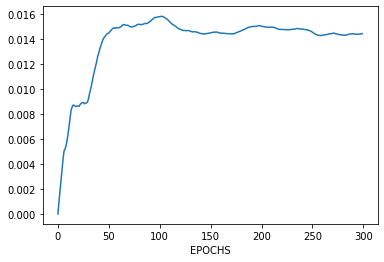

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(0,300)],alpha)
plt.xlabel('EPOCHS')
plt.ylabel('alpha')
plt.show()

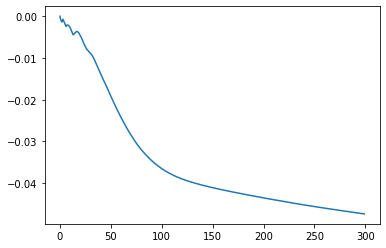

In [ ]:
plt.plot([i for i in range(0,300)],beta)
plt.xlabel('EPOCHS')
plt.ylabel('beta')
plt.show()

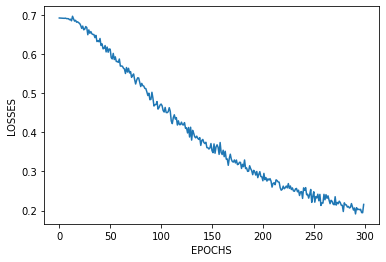

In [ ]:
plt.plot([i for i in range(0,300)],losses)
plt.xlabel('EPOCHS')
plt.ylabel('LOSSES')
plt.show()